In [1]:
print('hello')

hello


통계 분석

1. 품목별(Item ID)
* 평균 이동 횟수
* 최대/최소 이동량

2. 창고별(Warehouse ID)
* 평균 이동 횟수
* 최대/최소 이동량

시간별 트렌드 분석
* 일/주/월별 전체 이동량 및 이동 횟수 변화 시각화
 - 주기성이나 갑작스러운 변동 감지

* 일/주/월별 Top5 이동 품목

* 일/주/월별 Top5 이동 창고

* 입/출고 시간대 분석
 - 입고 및 출고가 특정 시간대에 집중하는지 확인
 - Movement Date

재고 회전율 분석
* 특정 기간(예: 2025년 5월)동안 각 품목이 입고/출고된 횟수
* 회전률이 낮은 품목

추가 인사이트
* Movement Type에 따라 처리 시간을 확인할 수 있는 작업 소요 필드 필요.
* 작업 로그별 오류 횟수 필드가 있다면 오류 분석에 유용할 것.


# 라이브러리 설치

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
import numpy as np

In [150]:
import plotly.express as px

# 데이터 불러오기

In [3]:
data_location = './datasets/warehouse-inventory-movement-log.csv'
movement_log_df = pd.read_csv(data_location)
movement_log_df.head()

,movement_id,timestamp,item_id,item_name,sku,batch_number,quantity,uom,movement_type,source_location_id,source_location_name,destination_location_id,destination_location_name,operator_id,operator_name,reference_document,movement_reason,comments
0,MV000001,2024-03-04T08:19:00,ITM-1012,Plastic Storage Bin,SKU-PLB-002,BN-202403A,32,pieces,inbound,NaN,NaN,BIN-17C,"Aisle 5, Bin 17C",OP-003,Dana Patel,PO-20240302-11,replenishment,Morning delivery from supplier
1,MV000002,2024-03-04T09:42:15,ITM-1045,Aluminum Sheet Roll,SKU-ALM-019,ALM-2402-B,-5,rolls,outbound,RACK-2B,Rack 2B,NaN,NaN,OP-005,Luke Chang,SO-20240304-04,picking,Dispatched for order 1124
2,MV000003,2024-03-04T10:11:00,ITM-1008,Corrugated Box Large,SKU-CBX-003,NaN,100,pieces,inbound,NaN,NaN,BIN-9A,"Aisle 2, Bin 9A",OP-001,Samantha Lee,PO-20240302-06,replenishment,NaN
3,MV000004,2024-03-04T10:37:36,ITM-1030,Packing Tape Clear,SKU-PTC-015,PTC-20240301,-24,boxes,outbound,BIN-3E,"Aisle 1, Bin 3E",NaN,NaN,OP-007,Jayden Brooks,SO-20240304-07,picking,For express shipment
4,MV000005,2024-03-04T11:02:20,ITM-1024,Blue Pallet,SKU-PAL-001,NaN,12,pallets,inbound,NaN,NaN,DOCK-01,Receiving Dock 01,OP-009,Erika Schmidt,PO-20240301-27,replenishment,NaN


# 변수 정리


## 분석에 필요한 컬럼 남기기

In [11]:
# df = movement_log_df.iloc[:, :-4].copy()

df = movement_log_df.copy()
drop_vars = ['item_name', 'uom', 'destination_location_name', 'source_location_name',
             'operator_name', 'reference_document', 'comments']
df.drop(columns=drop_vars, axis=1, inplace=True)
df.head()

,movement_id,timestamp,item_id,sku,batch_number,quantity,movement_type,source_location_id,destination_location_id,operator_id,movement_reason
0,MV000001,2024-03-04T08:19:00,ITM-1012,SKU-PLB-002,BN-202403A,32,inbound,NaN,BIN-17C,OP-003,replenishment
1,MV000002,2024-03-04T09:42:15,ITM-1045,SKU-ALM-019,ALM-2402-B,-5,outbound,RACK-2B,NaN,OP-005,picking
2,MV000003,2024-03-04T10:11:00,ITM-1008,SKU-CBX-003,NaN,100,inbound,NaN,BIN-9A,OP-001,replenishment
3,MV000004,2024-03-04T10:37:36,ITM-1030,SKU-PTC-015,PTC-20240301,-24,outbound,BIN-3E,NaN,OP-007,picking
4,MV000005,2024-03-04T11:02:20,ITM-1024,SKU-PAL-001,NaN,12,inbound,NaN,DOCK-01,OP-009,replenishment


## 날짜에서 date, time 추출 및 시간 데이터 변환

In [12]:
df[['date', 'time']] = df['timestamp'].str.split('T', expand=True)
for i in ['timestamp', 'date']:
    df[i] = pd.to_datetime(df[i], errors='coerce')

df['time'] = pd.to_datetime(df['time'], errors='coerce', format='%H:%M:%S').dt.time
# dt.time으로 가짜 날짜 1900-01-01 제거하고 시간 정보만 추출
df.head()

,movement_id,timestamp,item_id,sku,batch_number,quantity,movement_type,source_location_id,destination_location_id,operator_id,movement_reason,date,time
0,MV000001,2024-03-04 08:19:00,ITM-1012,SKU-PLB-002,BN-202403A,32,inbound,NaN,BIN-17C,OP-003,replenishment,2024-03-04,08:19:00
1,MV000002,2024-03-04 09:42:15,ITM-1045,SKU-ALM-019,ALM-2402-B,-5,outbound,RACK-2B,NaN,OP-005,picking,2024-03-04,09:42:15
2,MV000003,2024-03-04 10:11:00,ITM-1008,SKU-CBX-003,NaN,100,inbound,NaN,BIN-9A,OP-001,replenishment,2024-03-04,10:11:00
3,MV000004,2024-03-04 10:37:36,ITM-1030,SKU-PTC-015,PTC-20240301,-24,outbound,BIN-3E,NaN,OP-007,picking,2024-03-04,10:37:36
4,MV000005,2024-03-04 11:02:20,ITM-1024,SKU-PAL-001,NaN,12,inbound,NaN,DOCK-01,OP-009,replenishment,2024-03-04,11:02:20


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   movement_id              200 non-null    object        
 1   timestamp                200 non-null    datetime64[ns]
 2   item_id                  200 non-null    object        
 3   sku                      200 non-null    object        
 4   batch_number             107 non-null    object        
 5   quantity                 200 non-null    int64         
 6   movement_type            200 non-null    object        
 7   source_location_id       112 non-null    object        
 8   destination_location_id  128 non-null    object        
 9   operator_id              200 non-null    object        
 10  movement_reason          200 non-null    object        
 11  date                     200 non-null    datetime64[ns]
 12  time                     200 non-nul

# 변수 탐색

In [44]:
df.head()

,movement_id,timestamp,item_id,sku,batch_number,quantity,movement_type,source_location_id,destination_location_id,operator_id,movement_reason,date,time
0,MV000001,2024-03-04 08:19:00,ITM-1012,SKU-PLB-002,BN-202403A,32,inbound,NaN,BIN-17C,OP-003,replenishment,2024-03-04,08:19:00
1,MV000002,2024-03-04 09:42:15,ITM-1045,SKU-ALM-019,ALM-2402-B,-5,outbound,RACK-2B,NaN,OP-005,picking,2024-03-04,09:42:15
2,MV000003,2024-03-04 10:11:00,ITM-1008,SKU-CBX-003,NaN,100,inbound,NaN,BIN-9A,OP-001,replenishment,2024-03-04,10:11:00
3,MV000004,2024-03-04 10:37:36,ITM-1030,SKU-PTC-015,PTC-20240301,-24,outbound,BIN-3E,NaN,OP-007,picking,2024-03-04,10:37:36
4,MV000005,2024-03-04 11:02:20,ITM-1024,SKU-PAL-001,NaN,12,inbound,NaN,DOCK-01,OP-009,replenishment,2024-03-04,11:02:20


In [43]:
df.describe()

,timestamp,quantity,date
count,200,200.000000,200
mean,2024-02-21 08:21:47.684999936,7.680000,2024-02-20 18:50:24
min,2023-10-02 08:13:28,-200.000000,2023-10-02 00:00:00
25%,2024-01-26 22:00:18.750000128,-8.000000,2024-01-26 12:00:00
50%,2024-03-18 16:16:08.500000,2.000000,2024-03-18 00:00:00
75%,2024-04-15 16:52:32,20.000000,2024-04-15 06:00:00
max,2024-05-17 16:29:44,300.000000,2024-05-17 00:00:00
std,NaN,54.341722,NaN


## 작업 기간 확인

In [ ]:
df['timestamp'].min(), df['timestamp'].max()
# 2023-10-02 ~ 2024-05-17

(Timestamp('2023-10-02 08:13:28'), Timestamp('2024-05-17 16:29:44'))

<Axes: xlabel='date'>

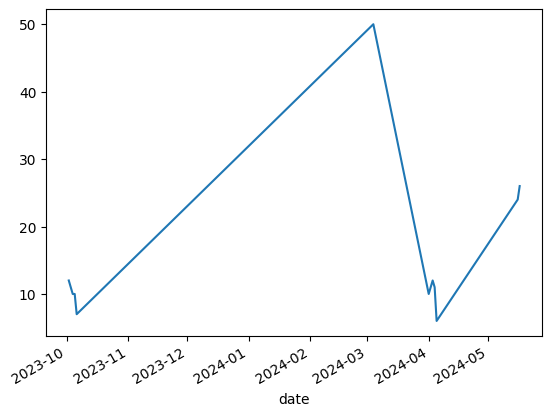

In [178]:
df.groupby('date').size().plot()

TypeError: '<' not supported between instances of 'datetime.time' and 'float'

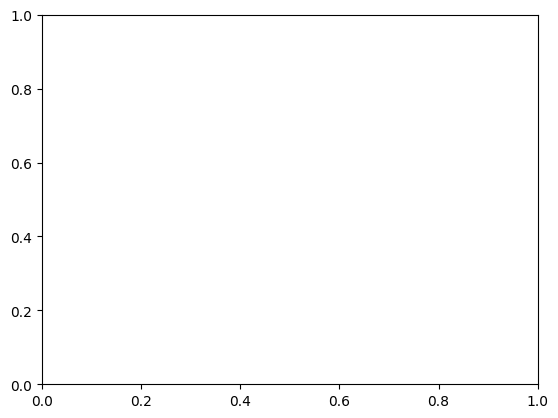

In [179]:
df['time'].hist(bins=24)

## 작업 종류(movement_type) 확인

* inbound(입고)

* outbound(출고)

* transfer(재고 이동)

|movement reason|설명|
|--|--|
|replenishment|보관존에 있던 상품을 피킹존으로 이동|
|shipping|출하 대기 중인 상품을 출하 게이트로 이동|
|reallocation|보관존에 있던 상품을 다른 보관존으로 이동|

* adjustment(수량 수정)

실제 재고와 시스템 재고 사이에 오차가 있을 때 일치시키기 위해 수정한 작업.<br>
cycle count시 수량이 추가되면 입고 오류, 진열 오류 등의 사유가 있음.<br>
파손 등의 이유로 판매가 불가능한 상품은 damage로 마이너스 처리.

In [ ]:
df['movement_type'].unique()

array(['inbound', 'outbound', 'transfer', 'adjustment', 'return'],
      dtype=object)

In [31]:
for i in df['movement_type'].unique() : 
    print(f"{i}: {df[df['movement_type'] == i]['movement_reason'].unique()}")

inbound: ['replenishment']
outbound: ['picking']
transfer: ['replenishment' 'shipping' 'reallocation']
adjustment: ['cycle count' 'damage']
return: ['customer return']


### 작업 종류, 작업 이유별 횟수

In [156]:
mov_reason_count = df.groupby('movement_reason').size().sort_values(ascending=False).reset_index(name='count')
mov_reason_count

,movement_reason,count
0,replenishment,74
1,picking,60
2,customer return,21
3,damage,19
4,cycle count,17
5,reallocation,7
6,shipping,2


In [157]:
mov_type_count = df.groupby('movement_type').size().sort_values(ascending=False).reset_index(name='count')
mov_type_count

,movement_type,count
0,inbound,67
1,outbound,60
2,adjustment,36
3,return,21
4,transfer,16


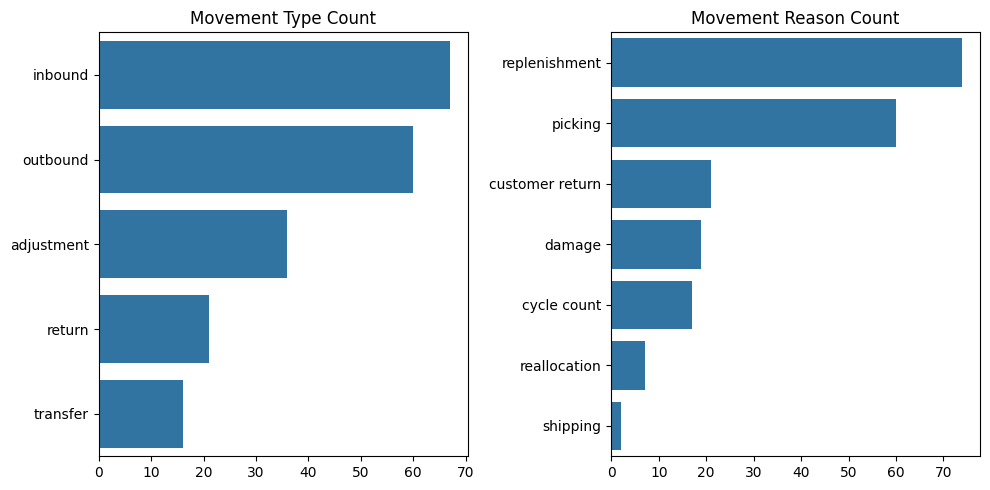

In [167]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.barplot(data = mov_type_count,
            x = 'count',
            y = 'movement_type',
            ax = ax[0])

sns.barplot(data = mov_reason_count,
            x = 'count',
            y = 'movement_reason',
            ax = ax[1])
ax[0].set_title('Movement Type Count')
ax[0].set_ylabel('')
ax[0].set_xlabel('')
ax[1].set_title('Movement Reason Count')
ax[1].set_ylabel('')
ax[1].set_xlabel('')

plt.tight_layout()

### 작업 종류별 quantity 분포

<Axes: xlabel='quantity', ylabel='Count'>

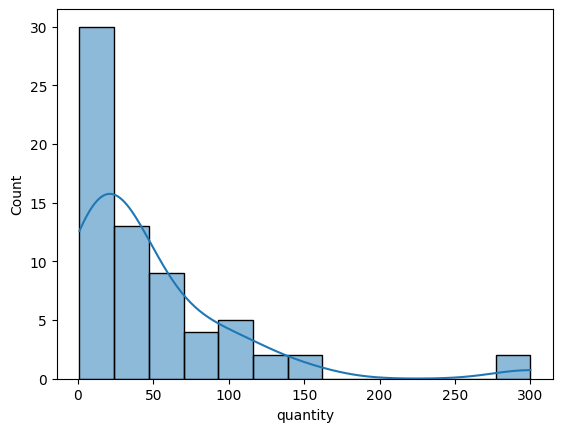

In [181]:
data = df[df['movement_type'] == 'inbound']['quantity']
sns.histplot(data, kde=True)

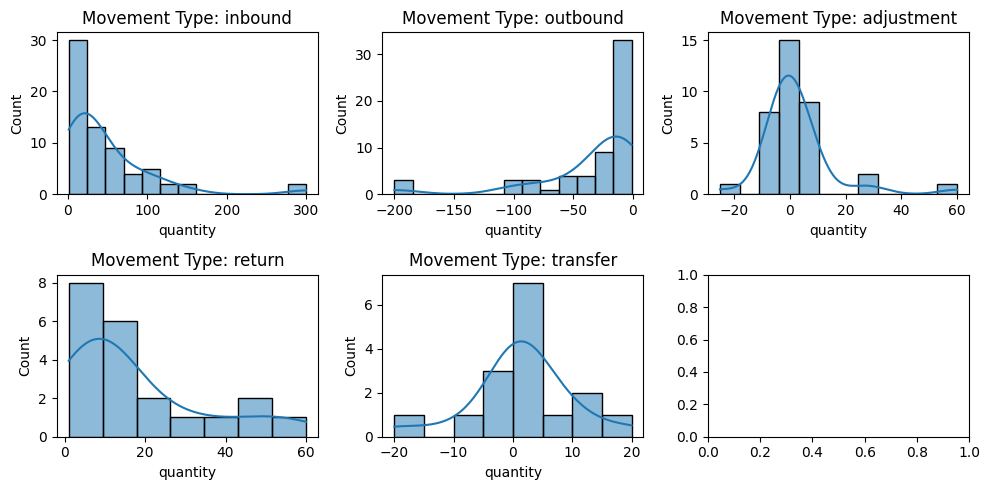

In [186]:
mov_type_var = ['inbound', 'outbound', 'adjustment', 'return', 'transfer']

fig, ax = plt.subplots(2, 3, figsize=(10, 5))
for x, i in enumerate(mov_type_var):
    data = df[df['movement_type'] == i]['quantity']
    sns.histplot(data, kde=True, ax=ax[x//3, x%3]).set_title(f'Movement Type: {i}')

plt.tight_layout()

In [155]:
df.head()

,movement_id,timestamp,item_id,sku,batch_number,quantity,movement_type,source_location_id,destination_location_id,operator_id,movement_reason,date,time
52,MV20240516-5003,2024-05-16 09:23:11,ITM-0089,ALSH-2MM-10,A1624F,1,transfer,DOCK-01,AISLE-5,OPR-109,replenishment,2024-05-16,09:23:11
59,MV20240516-5010,2024-05-16 11:37:19,ITM-0089,ALSH-2MM-10,A1624F,-1,transfer,AISLE-5,DOCK-03,OPR-105,shipping,2024-05-16,11:37:19
67,MV20240516-5018,2024-05-16 15:01:45,ITM-0089,ALSH-2MM-10,A1624F,1,adjustment,AISLE-5,AISLE-5,OPR-109,cycle count,2024-05-16,15:01:45
74,MV20240516-5025,2024-05-17 08:20:13,ITM-0089,ALSH-2MM-10,A1624F,-1,transfer,AISLE-5,DOCK-04,OPR-105,shipping,2024-05-17,08:20:13
80,MV20240516-5031,2024-05-17 10:22:44,ITM-0089,ALSH-2MM-10,A1624F,1,inbound,NaN,AISLE-5,OPR-105,replenishment,2024-05-17,10:22:44


## 존 정보 확인

### 로케이션 총 개수

In [71]:
df.sort_values(by=['sku', 'timestamp'], ascending=[True, True], inplace=True)

In [91]:
com = df['source_location_id'].unique().tolist() + df['destination_location_id'].unique().tolist()

In [ ]:
# 로케이션의 총 개수
com_list = list(set(com))
len(com_list)

90

In [97]:
com_list

['BIN-16G',
 'BIN-23D',
 'BIN-33B',
 'BIN-13A',
 'BIN-15F',
 'RACK-4C',
 'BIN-17C',
 'DOCK-03',
 'BIN-2B',
 'BIN-12B',
 'E1-D3-09',
 'C3-D4-03',
 'C1-A5-06',
 'BIN-16A',
 'BIN-2F',
 'BIN-21D',
 'BIN-11A',
 'E2-D5-12',
 'BIN-12C',
 'BIN-22F',
 'B2-D5-01',
 'BIN-11C',
 'BIN-21B',
 nan,
 'BIN-10B',
 'A1-D2-06',
 'A1-B2-05',
 'BIN-4C',
 'BIN-2K',
 'AIS-1A',
 'DOCK-01',
 'BIN-14D',
 'BIN-2A',
 'BIN-18A',
 'AIS-8F',
 'AIS-7E',
 'BIN-9F',
 'BIN-20C',
 'BIN-3D',
 'DOCK-04',
 'BIN-9D',
 'AISLE-5',
 'EQP-01',
 'BIN-7B',
 'D1-A3-09',
 'BIN-24A',
 'BIN-7C',
 'BIN-10D',
 'D3-C7-11',
 'AIS-4D',
 'BIN-9A',
 'AIS-7D',
 'BIN-18E',
 'BIN-3E',
 'BIN-23C',
 'BIN-3C',
 'BIN-8E',
 'BIN-6F',
 'BIN-24B',
 'BIN-8G',
 'B1-C2-11',
 'BIN-3B',
 'BIN-5E',
 'BIN-14E',
 'D2-C2-07',
 'A3-B3-10',
 'BIN-20A',
 'BIN-6B',
 'B4-D3-04',
 'BIN-19C',
 'DOCK-02',
 'A2-B6-04',
 'RACK-1A',
 'BIN-5D',
 'B2-C1-07',
 'E3-B4-08',
 'B3-C4-02',
 'BIN-12A',
 'C2-B1-04',
 'D2-B4-02',
 'AIS-2G',
 'RACK-2B',
 'S2-B1-10',
 'P3-PLT-03',
 'P

### 로케이션 타입 확인

피킹존 :
A, B, C, D, E, G, P, R, S
AIS
AISLE
BIN
DOCK
RACK

In [105]:
com_list_uniq = [i.split('-')[0] for i in com_list if isinstance(i, str)]
set(com_list_uniq)

{'A1',
 'A2',
 'A3',
 'AIS',
 'AISLE',
 'B1',
 'B2',
 'B3',
 'B4',
 'BIN',
 'C1',
 'C2',
 'C3',
 'D1',
 'D2',
 'D3',
 'DOCK',
 'E1',
 'E2',
 'E3',
 'EQP',
 'G1',
 'P1',
 'P2',
 'P3',
 'R1',
 'RACK',
 'S2'}

### 존 타입 별 로케이션 개수 확인

In [116]:
aisle_list = [i for i in com_list if isinstance(i, str) and ('AI' in i)]
bin_list = [i for i in com_list if isinstance(i, str) and ('BIN' in i)]
dock_list = [i for i in com_list if isinstance(i, str) and ('DOCK' in i)]
rack_list = [i for i in com_list if isinstance(i, str) and ('RACK' in i)]

In [121]:
zone_list = ['aisle_list', 'bin_list', 'dock_list', 'rack_list']
for i in zone_list:
    print(f'zone : {i} count : {len(eval(i))}')

zone : aisle_list count : 7
zone : bin_list count : 49
zone : dock_list count : 4
zone : rack_list count : 3


### 상품이 내보내진 횟수가 높은 로케이션

In [125]:
sor = df.groupby('source_location_id').size().reset_index(name='Source_Count')
des = df.groupby('destination_location_id').size().reset_index(name='Destination_Count')

In [132]:
loc_move_count = pd.merge(sor, des,
         left_on = 'source_location_id',
         right_on = 'destination_location_id',
         how = 'outer')
loc_move_count.sort_values(by='Source_Count', ascending=False).head(10)

,source_location_id,Source_Count,destination_location_id,Destination_Count
73,DOCK-02,6.0,DOCK-02,3.0
53,BIN-5B,5.0,BIN-5B,5.0
59,BIN-7C,5.0,BIN-7C,6.0
10,AISLE-5,4.0,AISLE-5,5.0
47,BIN-33B,4.0,BIN-33B,2.0
44,BIN-2B,4.0,BIN-2B,5.0
50,BIN-3D,4.0,BIN-3D,5.0
64,BIN-9F,4.0,BIN-9F,5.0
7,AIS-7D,3.0,AIS-7D,3.0
22,BIN-12C,3.0,BIN-12C,2.0


### 상품을 받은 횟수가 높은 로케이션

In [133]:
loc_move_count.sort_values(by='Destination_Count', ascending=False).head(10)

,source_location_id,Source_Count,destination_location_id,Destination_Count
59,BIN-7C,5.0,BIN-7C,6.0
20,BIN-12A,3.0,BIN-12A,5.0
44,BIN-2B,4.0,BIN-2B,5.0
10,AISLE-5,4.0,AISLE-5,5.0
53,BIN-5B,5.0,BIN-5B,5.0
50,BIN-3D,4.0,BIN-3D,5.0
64,BIN-9F,4.0,BIN-9F,5.0
5,AIS-2G,2.0,AIS-2G,4.0
8,AIS-7E,3.0,AIS-7E,3.0
0,A1-B2-05,1.0,A1-B2-05,3.0


In [ ]:
# 상품을 받은 횟수가 높아질 수록 내보내지는 횟수가 높아지는 경향 확인

loc_move_count['Source_Count'].corr(loc_move_count['Destination_Count'])

np.float64(0.7388573409301101)

<Axes: xlabel='Source_Count', ylabel='Destination_Count'>

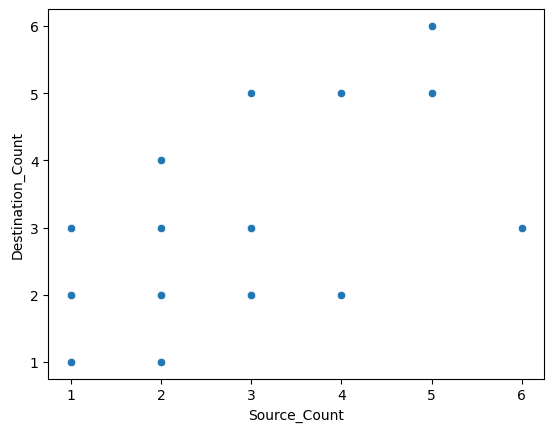

In [134]:
sns.scatterplot(data=loc_move_count, x='Source_Count', y='Destination_Count')

<Axes: xlabel='Source_Count', ylabel='Destination_Count'>

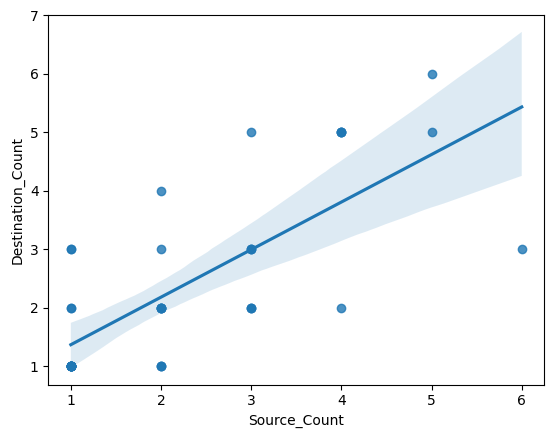

In [138]:
sns.regplot(data=loc_move_count, x='Source_Count', y='Destination_Count')

## 재고 수정 작업 확인

In [197]:
df_cycle = df[df['movement_reason'] == 'cycle count']
df_cycle.head()

,movement_id,timestamp,item_id,sku,batch_number,quantity,movement_type,source_location_id,destination_location_id,operator_id,movement_reason,date,time
67,MV20240516-5018,2024-05-16 15:01:45,ITM-0089,ALSH-2MM-10,A1624F,1,adjustment,AISLE-5,AISLE-5,OPR-109,cycle count,2024-05-16,15:01:45
117,MV3018,2023-10-03 11:56:21,ITM-0352,BIN-BLU-40,B20230930C,5,adjustment,C1-A5-06,C1-A5-06,OP-1010,cycle count,2023-10-03,11:56:21
68,MV20240516-5019,2024-05-16 15:29:27,ITM-0312,BNG-100B,GL202405,5,adjustment,BIN-3D,BIN-3D,OPR-112,cycle count,2024-05-16,15:29:27
118,MV3019,2023-10-03 12:12:22,ITM-0135,BW-50M-CLR,NaN,7,adjustment,A1-D2-06,A1-D2-06,OP-1004,cycle count,2023-10-03,12:12:22
140,MV3041,2023-10-05 14:02:22,ITM-0135,BW-50M-CLR,NaN,1,adjustment,A1-D2-06,A1-D2-06,OP-1004,cycle count,2023-10-05,14:02:22


### 총 재고 수정 횟수

In [ ]:

df_cycle.shape[0]

17

### 재고 수정이 발생한 로케이션별 총 작업 횟수량 수량

In [ ]:
# 재고 수정이 발생한 로케이션별 총 작업 횟수량 수량

df_cycle.groupby('source_location_id').agg(total_quantity = ('quantity', 'sum'),
                                          count = ('quantity', 'size')).reset_index()

,source_location_id,total_quantity,count
0,A1-D2-06,8,2
1,A2-B6-04,3,1
2,AIS-1A,10,1
3,AIS-7E,25,1
4,AISLE-5,1,1
5,B3-C4-02,2,2
6,BIN-2B,5,1
7,BIN-2K,60,1
8,BIN-33B,30,1
9,BIN-3D,5,1


In [200]:
df_cycle['is_correction'] = (df_cycle['source_location_id'] == df_cycle['destination_location_id'])
df_cycle['is_correction'].value_counts()

C:\Users\xo0ol\AppData\Local\Temp\ipykernel_22072\1826132216.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



is_correction
True     12
False     5
Name: count, dtype: int64

In [ ]:
# 재고 수정이 일어나면 이전 로케이션과 도착 로케이션이 동일해야 하는데, 다른 경우가 존재함.
# 시스템상 에러이거나, 시스템에서 제외되는 어떤 규칙일 가능성도 존재.

df_cycle[df_cycle['is_correction'] == False]

,movement_id,timestamp,item_id,sku,batch_number,quantity,movement_type,source_location_id,destination_location_id,operator_id,movement_reason,date,time,is_correction
176,MV4027,2024-04-03 11:29:08,IT1483,CPAL-010,NaN,2,adjustment,DOCK-02,NaN,EMP286,cycle count,2024-04-03,11:29:08,False
174,MV4025,2024-04-03 10:17:47,IT1205,LEDB-E27-25W,L20240401,10,adjustment,AIS-1A,NaN,EMP299,cycle count,2024-04-03,10:17:47,False
184,MV4035,2024-04-04 09:16:55,IT1592,PB-20X30,NaN,60,adjustment,BIN-2K,NaN,EMP299,cycle count,2024-04-04,09:16:55,False
170,MV4021,2024-04-02 15:50:03,IT1435,PCR-BLU-104,B23014,30,adjustment,BIN-33B,NaN,EMP286,cycle count,2024-04-02,15:50:03,False
172,MV4023,2024-04-03 08:58:26,IT1270,SB-M12-100,SB202403A,25,adjustment,AIS-7E,NaN,EMP202,cycle count,2024-04-03,08:58:26,False


### 재고 수정이 많이 일어난 로케이션

In [207]:
df_cycle.groupby('source_location_id').size().sort_values(ascending=False).head(5)

source_location_id
A1-D2-06    2
B3-C4-02    2
BIN-7C      2
A2-B6-04    1
AIS-7E      1
dtype: int64

## 파손 상품 확인

In [216]:
df[df['movement_reason'] == 'damage'].describe()

,timestamp,quantity,date
count,19,19.000000,19
mean,2024-03-14 21:54:28.842105088,-4.157895,2024-03-14 08:50:31.578947328
min,2023-10-03 13:35:51,-25.000000,2023-10-03 00:00:00
25%,2024-04-03 09:26:42,-5.000000,2024-04-03 00:00:00
50%,2024-04-04 14:11:12,-3.000000,2024-04-04 00:00:00
75%,2024-05-16 16:39:31,-1.500000,2024-05-16 00:00:00
max,2024-05-17 16:29:44,-1.000000,2024-05-17 00:00:00
std,NaN,5.356856,NaN


### 일자별 파손 횟수/수량 파악

In [274]:
df_damage = df[df['movement_reason'] == 'damage']
df_damage.head()

,movement_id,timestamp,item_id,sku,batch_number,quantity,movement_type,source_location_id,destination_location_id,operator_id,movement_reason,date,time
99,MV20240516-5050,2024-05-17 16:29:44,ITM-0089,ALSH-2MM-10,A1624F,-1,adjustment,AISLE-5,AISLE-5,OPR-105,damage,2024-05-17,16:29:44
175,MV4026,2024-04-03 10:48:23,IT1550,ALT-1000-09,NaN,-2,adjustment,AIS-7D,NaN,EMP253,damage,2024-04-03,10:48:23
131,MV3032,2023-10-04 15:06:17,ITM-0352,BIN-BLU-40,NaN,-2,adjustment,C1-A5-06,C1-A5-06,OP-1010,damage,2023-10-04,15:06:17
79,MV20240516-5030,2024-05-17 10:03:19,ITM-0312,BNG-100B,GL202405,-3,adjustment,BIN-3D,BIN-3D,OPR-113,damage,2024-05-17,10:03:19
183,MV4034,2024-04-04 08:28:07,IT1483,CPAL-010,NaN,-1,adjustment,DOCK-02,NaN,EMP267,damage,2024-04-04,08:28:07


<Axes: >

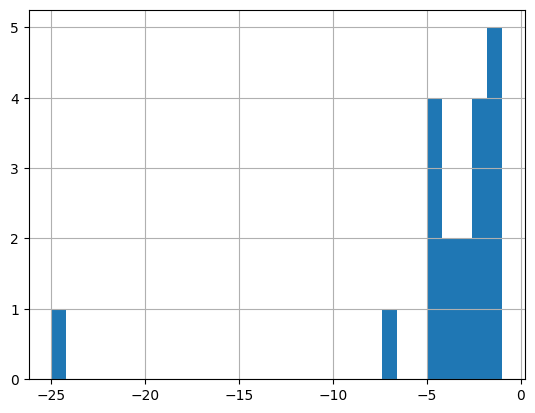

In [275]:
df_damage['quantity'].hist(bins=30)

In [276]:
damage_count = df_damage.groupby(['date']).agg(
    total_quantity=('quantity', 'sum'),
    count=('quantity', 'size')).reset_index()

In [277]:
df_date = df['date'].unique()
df_date = pd.DataFrame(df_date, columns=['date'])

In [278]:
df_damage_date = pd.merge(df_date,
         damage_count,
         on='date',
         how='left').sort_values(by='date').set_index('date')
df_damage_date

,total_quantity,count
date,,
2023-10-02,NaN,NaN
2023-10-03,-1.0,1.0
2023-10-04,-2.0,1.0
2023-10-05,-5.0,1.0
2023-10-06,-1.0,1.0
2024-03-04,NaN,NaN
2024-04-01,NaN,NaN
2024-04-02,NaN,NaN
2024-04-03,-7.0,2.0


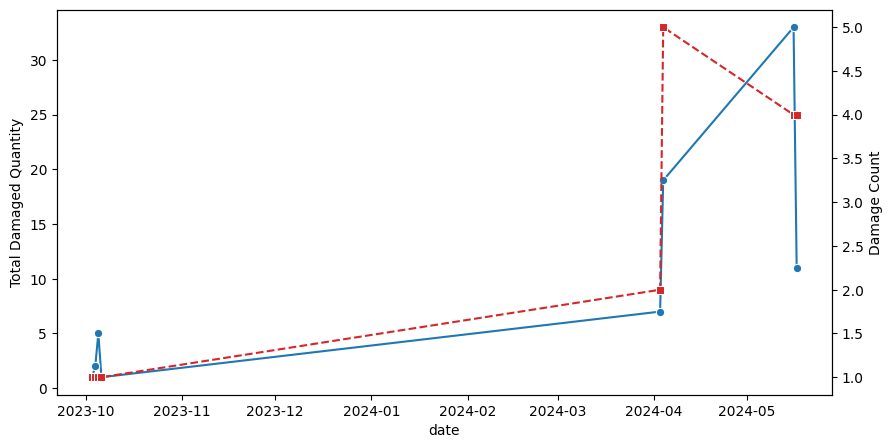

In [279]:
fig, ax1 = plt.subplots(figsize=(10, 5))

sns.lineplot(data=df_damage_date, 
             x=df_damage_date.index, 
             y=df_damage_date['total_quantity'].abs(), 
             ax=ax1,
             marker='o')
ax1.set_ylabel('Total Damaged Quantity')

ax2 = ax1.twinx()
sns.lineplot(data=df_damage_date, 
             x=df_damage_date.index, 
             y=df_damage_date['count'], 
             ax=ax2, 
             color='tab:red',
             marker='s',
             linestyle='--')
ax2.set_ylabel('Damage Count')

plt.show()

### 파손이 자주 일어난 로케이션

In [281]:
df_damage['source_location_id']

99      AISLE-5
175      AIS-7D
131    C1-A5-06
79       BIN-3D
183     DOCK-02
189      AIS-1A
191      AIS-4D
193     BIN-33B
119    S2-B1-10
72       BIN-7C
69       BIN-5B
94       BIN-5B
71       BIN-9F
171     BIN-12C
78       BIN-2B
148    D1-A3-09
62      BIN-12A
134    G1-A2-03
190      AIS-8F
Name: source_location_id, dtype: object

## 입고/출고 작업 확인

### 입고 작업이 많은 상품

### 출고 작업이 많은 상품